# HDS5210-2023 Final Project
**Anusha Cherupalla**

Healthcare disparities persist worldwide, reflecting inequities in access, quality, and outcomes, disproportionately affecting marginalized communities and underscoring the urgent need for targeted interventions to achieve health equity.

Three distinct datasets, encompassing county-level data for Missouri in 2018, were employed to investigate various metrics of healthcare disparities.
- Medicare/Medicaid dual enrollees
- Area Deprivation Index
- Social Vulnerability Index

Analyzing data from Medicare/Medicaid dual enrollees, the Social Vulnerability Index (SVI), and area deprivation at the county level in Missouri for the year 2018 is crucial for identifying and addressing health disparities. By integrating these datasets, the project can pinpoint specific areas where vulnerable populations face barriers to healthcare access, allowing for targeted resource allocation and intervention strategies. Policymakers can use the insights to formulate evidence-based policies that promote health equity, while local health agencies and community organizations can tailor outreach programs to address the unique needs of each county. The analysis facilitates a data-driven approach to decision-making, enabling stakeholders to make informed choices about healthcare resource distribution. Moreover, establishing a baseline in 2018 provides a foundation for ongoing monitoring and evaluation, allowing for the assessment of the effectiveness of interventions and policies over time and ensuring continuous improvement in healthcare outcomes.

## 1. Data Merging, Cleaning, Transformation

### 1-1. Data Sources

The following data were retrieved:
- Counts of Medicare-Medicaid dual enrollees (including those in Medicare Savings Programs), by eligibility type, who were enrolled in a given month (csv format). Downloaded from Google BigQuery as a local file.
- Area Deprivation Index: calculated using 17 different indicators, encompassing income, education, employment, and housing conditions (csv format). Downloaded from Google BigQuery as a local file.
- Social Vulnerability Index: which indicates the relative vulnerability of every U.S. Census tract in 2018 (JSON format): https://data.cdc.gov/resource/48va-t53r.json
    - About the SVI Data: https://data.cdc.gov/Health-Statistics/Social-Vulnerability-Index-2018-United-States-coun/48va-t53r/about_data

### 1-2. Medicare/Medicaid Dual Enrollees Data

**Pseudocode:**

Read in the dual dataframe from local file. Convert the 'Date' column to datetime so that the year can be extracted and stored in a separate column, so that we can condense the dataframe to include only the data from 2018. Aggregate the dataframe by the 'FIPS' ccode so that each row is a separate FIPS code and summate the individual parameter values for each FIPS code.

In [1]:
# read in the dual enrollment file from locally downloaded file
import pandas as pd
dual = pd.read_csv('/Users/anushacherupalla/Downloads/dual_enrollment')

In [2]:
# convert 'Date' column to datetime type and store year in separate 'Year' column
# condense dataframe to include only data in the year 2018
dual['Year'] = pd.to_datetime(dual['Date']).dt.year
dual = dual[dual['Year'] == 2018]

In [3]:
def group_by(df, groupby_column, exclude_columns):
    """(df, str, list) -> df
    This function takes the parameters of a dataframe, a string name for the column to groupby and columns
    to exclude in the aggregation to aggregate a dataframe by a certain column.
    """
    return df.groupby(groupby_column).agg(lambda x: x.iloc[0] 
                  if x.name not in exclude_columns 
                  else x.iloc[-1]).reset_index()

In [4]:
# store the columns to exclude and use the group_by function to group by FIPS code
# so each row is contains information for one county (FIPS)
exclude = ['State_Abbr', 'County_Name', 'Date', 'Year']
dual = group_by(dual, 'FIPS', exclude)

### 1-3. Area Deprivation Index Data

**Pseudocode:**

Read in the dual dataframe from local file. Condense the dataframe to include only the data from 2018.

In [5]:
# read in the adi file from locally downloaded file
adi = pd.read_csv("/Users/anushacherupalla/Downloads/adi")

In [6]:
# condense dataframe to include only data in the year 2018
adi = adi[adi['year'] == 2018]

### 1-4. Merged Dual and ADI Data

**Pseudocode:**

Merge both the dual and adi dataframes by performing an inner join. Drop any redundant columns.

In [7]:
# perform an inner join on both dual and adi dataframes
# drop redundant columns
dual_adi = pd.merge(adi, dual, left_on='county_fips_code', right_on='FIPS', how='inner')
dual_adi = dual_adi.drop(columns=['FIPS', 'Date', 'Year'], axis=1)

### 1-5. Social Vulnerability Index Data

In [8]:
# read in the SVI JSON file using the following link
svi = pd.read_json("https://data.cdc.gov/resource/48va-t53r.json")

### 1-6. Merged Dual, ADI, SVI Data and Transformation

**Pseudocode:**

Perform a left join with the left data being the merged dual_adi dataframe and the right dataframe being the svi dataframe. Then drop the redundant columns to clean up the data. Condense the data only keeping the data from Missouri. Set 'County_Name' as the index. Create a pivot table which shows the count of numeric values and Nan values in each column. 

In [9]:
# perform a left join of dual_adi combined dataframes and the svi dataframe
# drop redundant and unnecessary columns
df = pd.merge(dual_adi, svi, left_on='county_fips_code', right_on='fips', how='left')

In [11]:
# condense the combined df to only data in Missouri 
df_mo = df[df['state_name'] == 'Missouri']

In [13]:
# drop redundant columns
drop_columns = [
    'fips',
    'shape',
    'state_fips_code', 
    'State_Abbr', 
    'county_name',
    'st',
    'state_y',
    'st_abbr',
    'location',
    'state_name', 
    'state_x',
    'year']

df_mo.drop(columns=drop_columns, inplace=True)

/var/folders/b4/br6hbm31319d4dfd73df5f680000gn/T/ipykernel_73387/853899401.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mo.drop(columns=drop_columns, inplace=True)


In [14]:
df_mo.set_index('County_Name', inplace=True)

In [15]:
# identify columns with non-zero values
keep_columns = df_mo.columns[df_mo.fillna(0).ne(0).any()]

# filter the df to keep only columns with values other than 0.0 or NaN
df_mo= df_mo[keep_columns]

In [16]:
# FUNCTION IT
# initialize lists to append to
#column_names = []
#num_values_list = []
#num_nan_list = []

# iterate through columns in the df_mo
#for column in df_mo.columns:
#    num_values = df_mo[column].count()
#    num_nan = df_mo[column].isna().sum()
    
    # append information to initialized lists
#    column_names.append(column)
#    num_values_list.append(num_values)
#    num_nan_list.append(num_nan)

# create a new df using the lists
#df_columns = pd.DataFrame({
#    'Column_Name': column_names,
#    'Num_Values': num_values_list,
#    'Num_NaN': num_nan_list
#})

# display the resulting df
#df_columns

In [17]:
#def get_column_info(df):
#    """df1 -> df2
#    This function takes a dataframe as input and outputs a different dataframe with each column
#    name and the corresponding count of values and NaN values.
#    """
    # initialize lists to append to
#    column_names = []
#    num_values_list = []
#    num_nan_list = []

    # iterate through columns in the df_mo
#    for column in df.columns:
#        num_values = df[column].count()
#        num_nan = df[column].isna().sum()

        # append information to initialized lists
#        column_names.append(column)
#        num_values_list.append(num_values)
#        num_nan_list.append(num_nan)

    # create a new df using the lists
#    df_columns = pd.DataFrame({
#        'Column_Name': column_names,
#        'Num_Values': num_values_list,
#        'Num_NaN': num_nan_list
#    })

#    return df_columns

In [18]:
#df_columns = get_column_info(df_mo)

In [19]:
#nan_rows_indices = df_mo[df_mo['e_uninsur'].isna()].index

In [20]:
#pivot_df = df_mo.pivot(index='Indicators', columns='County_Name', values=value_column)

In [21]:
def get_column_info(df):
    """df1 -> df2
    This function takes a dataframe as input and outputs a pivot table with each column
    name and the corresponding count of values and NaN values.
    """
    # initialize lists to append to
    column_names = []
    num_values_list = []
    num_nan_list = []

    # iterate through columns in the DataFrame
    for column in df.columns:
        num_values = df[column].count()
        num_nan = df[column].isna().sum()

        # append information to initialized lists
        column_names.append(column)
        num_values_list.append(num_values)
        num_nan_list.append(num_nan)

    # create a new DataFrame using the lists
    df_columns = pd.DataFrame({
        'Column_Name': column_names,
        'Num_Values': num_values_list,
        'Num_NaN': num_nan_list
    })

    # create a pivot table
    df_pivot = df_columns.pivot_table(index='Column_Name', values=['Num_Values', 'Num_NaN'], aggfunc='sum')

    return df_pivot

In [22]:
df_mo_pivot = get_column_info(df_mo)

In [23]:
df_mo_pivot

,Num_NaN,Num_Values
Column_Name,,
Other_full,1,114
Public_Total,0,115
QI,11,104
QMB_Only,3,112
QMB_plus_Full,0,115
...,...,...
spl_theme1,54,61
spl_theme2,54,61
spl_theme3,54,61


In [24]:
df_mo.describe()

,county_fips_code,area_deprivation_index_percent,QMB_Only,QMB_plus_Full,SLMB_only,SLMB_plus_Full,QI,Other_full,Public_Total,area_sqmi,...,epl_groupq,spl_theme4,rpl_theme4,spl_themes,rpl_themes,e_uninsur,m_uninsur,ep_uninsur,mp_uninsur,e_daypop
count,115.000000,115.000000,112.000000,115.000000,114.000000,111.000000,104.000000,114.000000,115.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01
mean,29117.713043,61.365217,131.348214,767.756522,150.175439,109.522523,79.740385,309.877193,1529.556522,579.164253,...,0.469515,2.247075,0.396425,6.895490,0.421518,4649.360656,486.508197,10.785246,1.901639,5.148438e+04
std,75.816001,22.658537,233.558554,1531.249980,264.017237,209.290657,128.248923,685.461451,3016.428844,135.230972,...,0.233169,0.524338,0.226439,1.404018,0.217534,9090.743424,423.014878,3.609979,0.949472,1.409583e+05
min,29001.000000,3.000000,13.000000,26.000000,12.000000,12.000000,11.000000,18.000000,53.000000,266.628523,...,0.072900,1.198400,0.042300,3.868200,0.032500,138.000000,46.000000,4.900000,0.300000,1.357000e+03
25%,29058.000000,45.500000,35.000000,209.500000,40.250000,31.000000,25.250000,75.500000,410.500000,474.482756,...,0.301800,1.814000,0.190100,5.805500,0.231200,969.000000,212.000000,8.400000,1.200000,6.923000e+03
50%,29115.000000,66.000000,70.000000,384.000000,74.500000,54.000000,44.500000,138.000000,778.000000,563.286663,...,0.472800,2.338100,0.404000,7.064700,0.434100,1965.000000,338.000000,10.000000,1.700000,1.445900e+04
75%,29172.000000,78.500000,133.250000,693.500000,143.250000,98.500000,76.250000,247.250000,1363.000000,656.506730,...,0.681900,2.596000,0.546300,8.029500,0.599400,4650.000000,652.000000,13.000000,2.300000,3.941000e+04
max,29510.000000,98.000000,1667.000000,10183.000000,1868.000000,1458.000000,855.000000,5259.000000,20841.000000,927.248011,...,0.893700,3.259900,0.873900,9.335800,0.816200,65873.000000,2505.000000,22.800000,4.500000,1.050779e+06


## 2 - Data Visualization

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 2.1 - Area Deprivation Index Percent Distribution: MO v. US

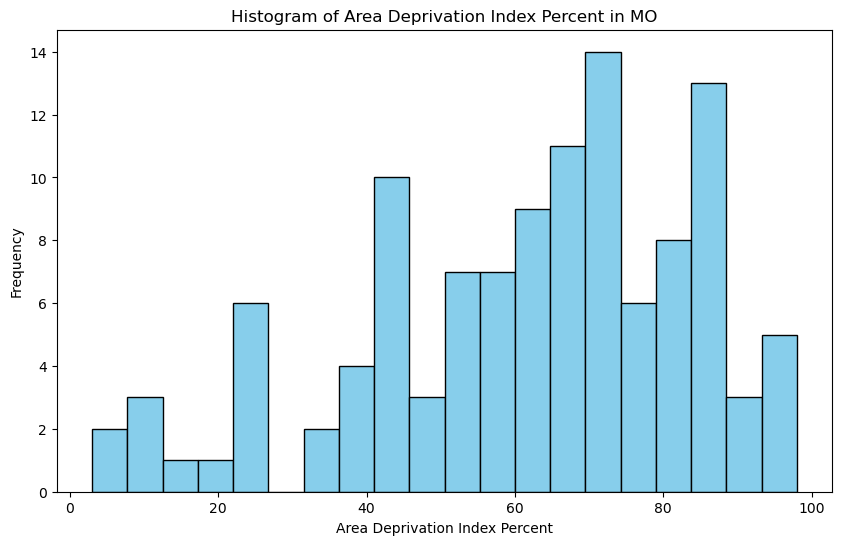

In [26]:
# create a histogram looking at the distribution of ADI in MO
plt.figure(figsize=(10, 6))
plt.hist(df_mo['area_deprivation_index_percent'].dropna(), bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Area Deprivation Index Percent')
plt.ylabel('Frequency')
plt.title('Histogram of Area Deprivation Index Percent in MO')

plt.show()

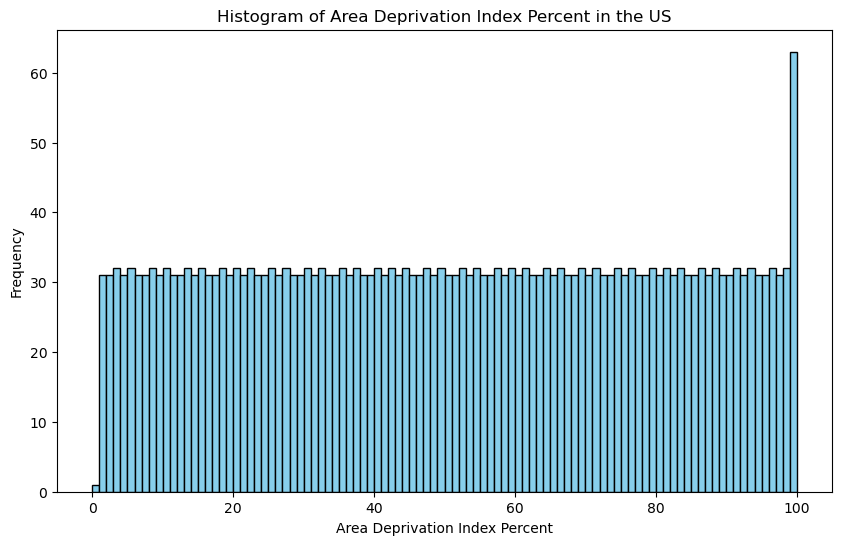

In [27]:
# create a histogram looking at the distribution of ADI in MO
plt.figure(figsize=(10, 6))
plt.hist(adi['area_deprivation_index_percent'].dropna(), bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Area Deprivation Index Percent')
plt.ylabel('Frequency')
plt.title('Histogram of Area Deprivation Index Percent in the US')

plt.show()

In [28]:
#plot_columns = ['QMB_Only', 'QMB_plus_Full', 'SLMB_only', 'SLMB_plus_Full', 'QDWI', 'QI', 'Other_full', 'Public_Total']

#plt.figure(figsize=(12, 8))

# FUNCTION IT
# filter out outliers based on IQR
#filtered_df = df_mo.copy()
#for column in plot_columns:
#    Q1 = df_mo[column].quantile(0.25)
#    Q3 = df_mo[column].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#    filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]

#sns.boxplot(data=filtered_df[plot_columns])

#plt.xlabel('Columns')
#plt.ylabel('Values')
#plt.title('Box and Whisker Plot of Selected Columns (Outliers Removed)')

#plt.show()

def filter_outliers(df, columns_to_filter):
    """(df, list) -> df
    This function takes a dataframe and a list of columns and outputs a dataframe with the outliers
    (based on IQR) removed.
    """
    filtered_df = df.copy()
    
    for column in columns_to_filter:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    
    return filtered_df
    
resulted in just 19 rows...

column_list = df_mo.columns.tolist()
num_column_list = [column for column in column_list if pd.api.types.is_numeric_dtype(df_mo[column])]

df_no_outliers = filter_outliers(df_mo, num_column_list)

### 2.2 - Box and Whisker Plot of Medicare/Medicaid Enrollment Parameters

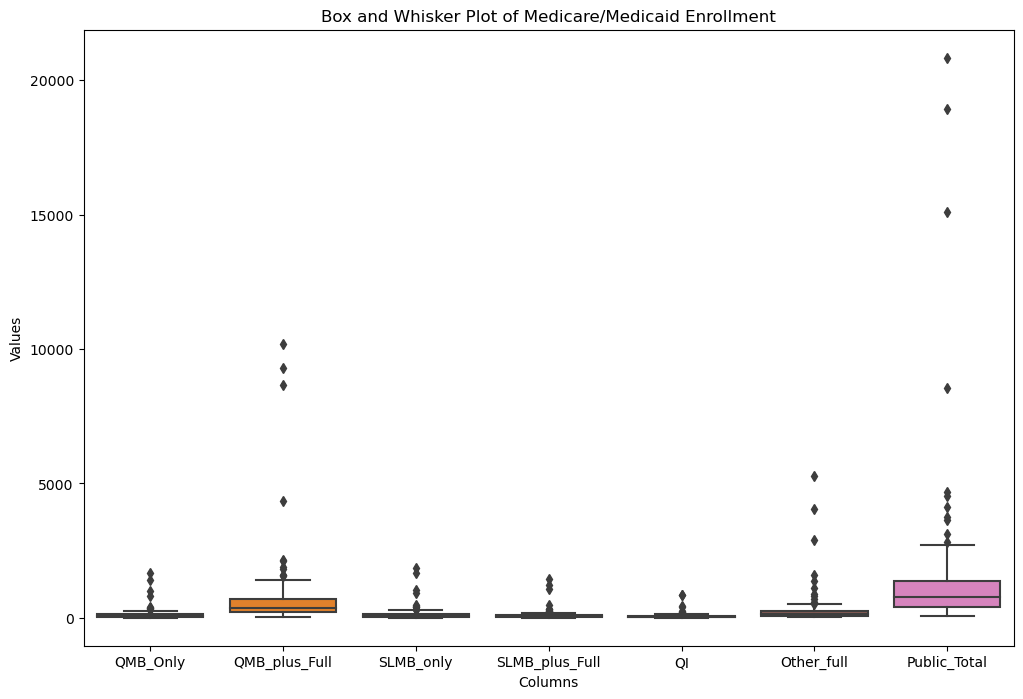

In [29]:
plot_columns = ['QMB_Only', 'QMB_plus_Full', 'SLMB_only', 'SLMB_plus_Full','QI', 'Other_full', 'Public_Total']

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_mo[plot_columns])
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box and Whisker Plot of Medicare/Medicaid Enrollment')

plt.show()

### 2.2 - Relationship between Per Capita Income and Total Enrollees across all Dual Eligible Programs

In [30]:
#df_mo.columns.tolist()

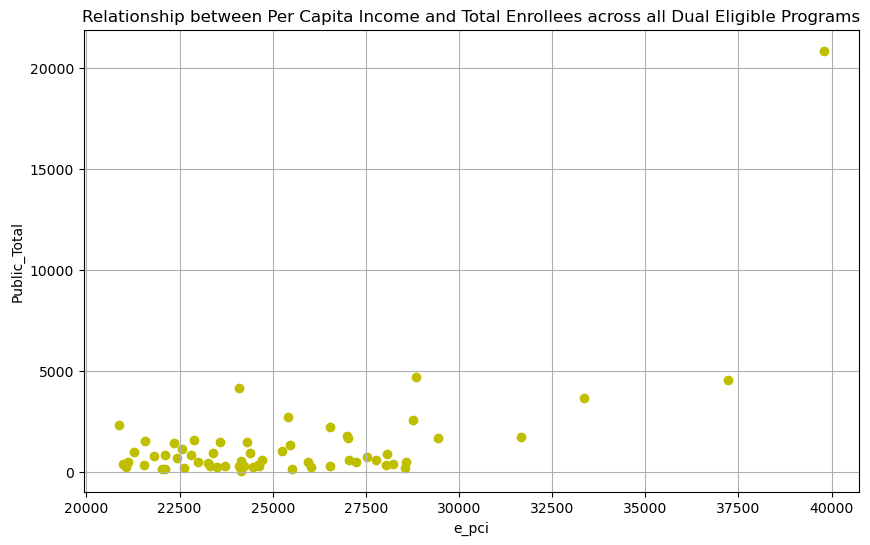

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df_mo['e_pci'], df_mo['Public_Total'], marker='o', linestyle='-', color='y')
plt.title('Relationship between Per Capita Income and Total Enrollees across all Dual Eligible Programs')
plt.xlabel('e_pci')
plt.ylabel('Public_Total')
plt.grid(True)
plt.show()